In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys 
import numpy as np 
import pandas as pd 
sys.path.append('../scripts/')
import paired_embeddings_models as pem
from DataSetImagePresence import DataSetImagePresence
import loadpaths_pecl
path_dict_pecl = loadpaths_pecl.loadpaths('tplas')  # loads default paths and example data
import torch
import torch.nn.functional as F


/opt/anaconda3/envs/pecl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/pecl/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/envs/pecl/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /opt/anaconda3/envs/pecl/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/opt/anaconda3/envs/pecl/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/anaconda3/envs/pecl/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

## Load data set:
- By default, an example data set of 16 data points will be loaded (contained inside the repo).

In [3]:
ds = DataSetImagePresence(image_folder=path_dict_pecl['s2bms_images'],
                        presence_csv=path_dict_pecl['s2bms_presence'],
                        species_process='all',
                        shuffle_order_data=False,
                        zscore_im=True, use_testing_data=False,
                        augment_image=False, mode='train')

Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.


This data class holds a `pd.DataFrame` of all data point id and their labels (=species probabilities). The image files are not kept in memory, but loaded on the go.

Check out the data points in `ds.df_presence`. The id of a data point is in column `name_loc`, its geographic coordinates are in `tuple_coords`, the number of visits to that location (by surveyors) in `n_visits`, and all other columns are species names (and their occurrence probabilities).

In [4]:
ds.df_presence.head()

,tuple_coords,Melanargia galathea,Pieris napi,Aphantopus hyperantus,Aglais io,Polyommatus icarus,Vanessa atalanta,Lycaena phlaeas,Pararge aegeria,Gonepteryx rhamni,...,Tyria jacobaeae,Euclidia glyphica,Odezia atrata,Melitaea cinxia,Carterocephalus palaemon,Nymphalis polychloros,Nymphalis antiopa,Erebia epiphron,n_visits,name_loc
0,"(-2.165105, 50.956811)",0.297872,0.404255,0.255319,0.319149,0.744681,0.297872,0.553191,0.723404,0.765957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,UKBMS_loc-0000
1,"(-2.646667, 50.775285)",0.305085,0.533898,0.296610,0.271186,0.610169,0.271186,0.203390,0.805085,0.279661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118,UKBMS_loc-0001
2,"(-0.828484, 50.888106)",0.300000,0.450000,0.400000,0.250000,0.650000,0.400000,0.550000,1.000000,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,UKBMS_loc-0002
3,"(-1.966038, 50.59722)",0.300885,0.115044,0.185841,0.318584,0.707965,0.469027,0.247788,0.884956,0.044248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113,UKBMS_loc-0003
4,"(-0.229941, 52.409243)",0.020833,0.791667,0.291667,0.541667,0.083333,0.312500,0.020833,0.958333,0.479167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48,UKBMS_loc-0004


In [5]:
print(f'Images will be loaded from {ds.image_folder} by matching name_loc')

## For example, load the satellite image corresponding to UKBMS_loc-0003:
example_image = ds.load_image('UKBMS_loc-0003')
print(example_image.shape)  # (4, 256, 256) for Sentinel-2 bands (RGB + NIR)

Images will be loaded from /Users/tplas/data/S2BMS/sentinel2_satellite-images/y-2018-2019_m-06-09/ by matching name_loc
(4, 256, 256)


In practice, data is loaded just by indexing:

In [6]:
example_datapoint = ds[0]
assert len(example_datapoint) == 2  # (image, presence_label)
print(example_datapoint[0].shape)  # (4, 256, 256) for Sentinel-2 bands (RGB + NIR)
assert example_datapoint[1].shape[0] == ds.n_species  # n_species
print(f'There are {ds.n_species} species in the dataset.')

torch.Size([4, 256, 256])
There are 62 species in the dataset.


Quickly visualise an image (the RGB bands) by plotting, either name or index based:

(<AxesSubplot: title={'center': 'UKBMS_loc-0003, id 3'}>, <Axes: >)

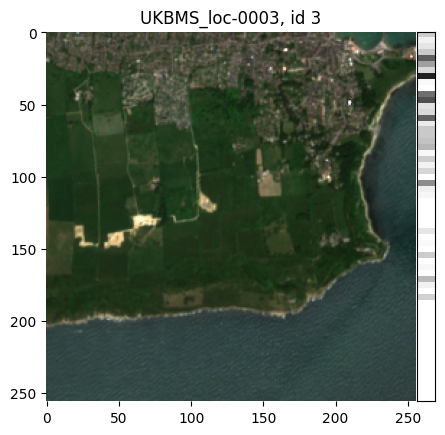

In [7]:
ds.plot_image(loc_name='UKBMS_loc-0003')
# ds.plot_image(index=3)

## Note that in this case index=3 corresponds to UKBMS_loc-0003, because the data is NOT shuffled.

Lastly, split the data using the existing data split (which accounts for spatial clustering):

In [8]:
tmp = os.path.join(path_dict_pecl['repo'], 'tests/data_test/split_indices_s2bms_2024-08-15-1923_data-test.pth')
train_ds, val_ds, test_ds = ds.split_into_train_val(tmp)
print(len(train_ds), len(val_ds), len(test_ds), len(ds))

10 3 3 1329


## Create model:

In [9]:
model = pem.ImageEncoder(n_species=ds.n_species, 
                         n_enc_channels=256,  # Size embedding space
                             n_layers_mlp_resnet=1, n_layers_mlp_pred=3,
                             pred_train_loss='bce', 
                            pretrained_resnet='imagenet', freeze_resnet=True,  # Freeze ResNet except for MLPs on top
                            optimizer_name='Adam', resnet_version=18,
                            pecl_distance_metric='softmax', temperature=0.5,  # Temperature for softmax in PECL loss
                            pecl_knn=2,  # Number of nearest neighbors to use in PECL loss
                            pecl_knn_hard_labels=False,  # Use soft or hard labels for nearest neighbors in PECL loss
                            lr=1e-3, n_bands=ds.n_bands, 
                            use_mps=False,  # If True, use macbook M chip GPU
                            use_lr_scheduler=False,
                            training_method='pred_and_pecl',  # use both pred and pecl losses
                            alpha_ratio_loss=1,  # Ratio between prediction and PECL loss
                            p_dropout=0, 
                            batch_size_used=4,
                            verbose=1, seed_used=0)

No class weights.
Loaded Resnet18 with IMAGENET1K_V1 weights.
Freezing all but last layer: True, last layer: False.
Freezing prediction model: False.


In [ ]:
example_im_batch = torch.stack([ds[ii][0] for ii in range(4)])  # Batch of 4 images
example_label_batch = torch.stack([ds[ii][1] for ii in range(4)])  # Batch of 4 labels
print(f'Shapes: {example_im_batch.shape}, {example_label_batch.shape}')

example_im_embedding = model.forward(example_im_batch)  # Forward pass with a single image
example_im_preds = model.prediction_model(example_im_embedding)  # Forward pass with a single image
print(f'Embedding shape: {example_im_embedding.shape}, Prediction shape: {example_im_preds.shape}')

model.k_bottom = 2  # decrease because of low batch size
pecl_loss, _ = model.pecl_loss(example_im_embedding, example_label_batch)
print(f'PECL loss: {pecl_loss}')

pred_loss = model.pred_loss(example_im_preds, example_label_batch)
print(f'Prediction loss: {pred_loss}')

Shapes: torch.Size([4, 4, 256, 256]), torch.Size([4, 62])
Embedding shape: torch.Size([4, 256]), Prediction shape: torch.Size([4, 62])
PECL loss: 0.8828564882278442
Prediction loss: 0.695761501789093


## Training

Training is done with `scripts/train.py` and `scipts/train_randomsearch.py`. 

These use `pem.train_pecl()` to call data, instantiate model, do training and save results. 